In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections as c

%matplotlib inline

In [2]:
df=pd.read_csv('../data/bbAllConvosDF.csv',sep=';')

/home/mako0970/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (31,32,34,35,36,38,39,40,42,43,44,46,47,48,50,51,52,54,55,56,58,59,60,62,63,64,66,67,68,70,71,72,74,75,76,78,79,80,82,83,84,86,87,88,90,91,92,94,95,96,98,99,100,102,103,104,106,107,108,110,111,112,114,115,116,118,119,120,122,123,124,126,127,128,130,131,132,134,135,136,138,139,140,142,143,144,146,147,148,150,151,152,154,155,156,158,159,160,162,163,164,166,167,168,170,171,172,174,175,176,178,179,180,182,183,184,186,187,188,190,191,192) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns

Index([u'id', u'username', u'user_id', u'geo_enabled', u'followCount',
       u'friendCount', u'faveCount', u'tweetCount', u'date', u'timing',
       ...
       u'reply41OrigReplyWhat', u'reply41OrigReplyWho', u'reply42OrigTime',
       u'reply42OrigText', u'reply42OrigReplyWhat', u'reply42OrigReplyWho',
       u'reply43OrigTime', u'reply43OrigText', u'reply43OrigReplyWhat',
       u'reply43OrigReplyWho'],
      dtype='object', length=195)

In [4]:
df['dateObj']=pd.to_datetime(df.date)

In [5]:
len(df[df.replyWhat!=0])

625731

In [6]:
inBBreps=df[df.replyOrigTime!='0'].copy()

** LIMIT the dataset only to tweets that reply to tweets we also have**

In [7]:
inBBreps['repSecDiff']=(inBBreps.dateObj-pd.to_datetime(inBBreps.replyOrigTime)).apply(lambda x: np.nan if pd.isnull(x) else x.item()/(10**9))

In [8]:
data = inBBreps.repSecDiff.dropna().tolist()

In [9]:
bins=np.logspace(0, int(np.log(max(data))), 100)
width=bins[1:]-bins[:-1]

(0, 0.08)

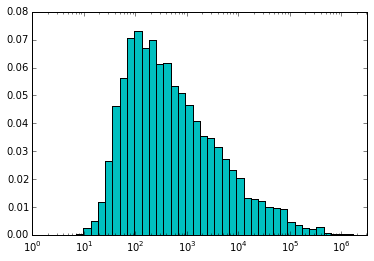

In [10]:
h, b=np.histogram(data,bins)
h=h/float(sum(h))
plt.bar(b[:-1], h, width, color='c')
#plt.plot(bins[:-1], fit[:-1]*width, linewidth=2)
plt.gca().set_xscale("log")
plt.xlim(xmin=0,xmax=10**6.5)
plt.ylim(ymin=0, ymax=0.08)

**Takeway**
* Inter-reply patterns are similar to inter-tweet time (in bbInterReplyTimeOneSide)
* This means that people have similar work session practices for reply activity as just tweets
* So when they reply has more to do with their own tweeting patterns than with the timing of the tweet they are replying to?
* The graph above somewhat confirms it: the long tail suggest that inter-arrival time seems consistent with Poisson process (?)
* **Look into this**
* There is a single work-session practice, but it doesn't have a meaningful center, as it's long-tailed

# Check inter-Reply time for different disaster stages

In [11]:
before=inBBreps[inBBreps.dateObj<pd.to_datetime('2012-10-27 00:00:00')]

In [12]:
during=inBBreps[(inBBreps.dateObj>=pd.to_datetime('2012-10-27 00:00:00')) & (inBBreps.dateObj<=pd.to_datetime('2012-11-04 11:59:59'))]

In [13]:
after=inBBreps[inBBreps.dateObj>=pd.to_datetime('2012-11-05 00:00:00')]

In [14]:
bSecDiff=before.repSecDiff.dropna().tolist()
dSecDiff=during.repSecDiff.dropna().tolist()
aSecDiff=after.repSecDiff.dropna().tolist()

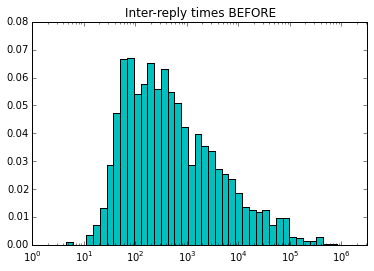

In [15]:
bins=np.logspace(0, int(np.log(max(bSecDiff))), 100)
width=bins[1:]-bins[:-1]
h, b=np.histogram(bSecDiff,bins)
h=h/float(sum(h))
plt.bar(b[:-1], h, width, color='c')
plt.gca().set_xscale("log")
plt.xlim(xmin=0,xmax=10**6.5)
plt.ylim(ymin=0,ymax=0.08)
plt.title('Inter-reply times BEFORE')

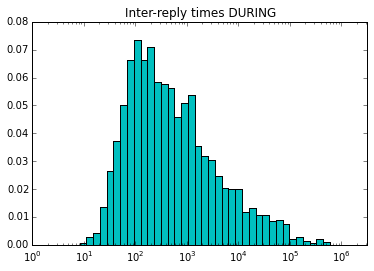

In [16]:
bins=np.logspace(0, int(np.log(max(dSecDiff))), 100)
width=bins[1:]-bins[:-1]
h, b=np.histogram(dSecDiff,bins)
h=h/float(sum(h))
plt.bar(b[:-1], h, width, color='c')
plt.gca().set_xscale("log")
plt.xlim(xmin=0,xmax=10**6.5)
plt.ylim(ymin=0,ymax=0.08)
plt.title('Inter-reply times DURING')

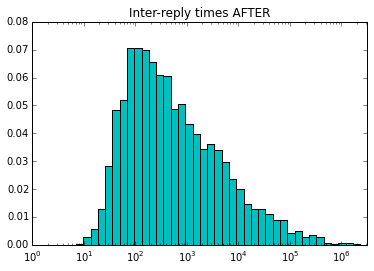

In [17]:
bins=np.logspace(0, int(np.log(max(aSecDiff))), 100)
width=bins[1:]-bins[:-1]
h, b=np.histogram(aSecDiff,bins)
h=h/float(sum(h))
plt.bar(b[:-1], h, width, color='c')
plt.gca().set_xscale("log")
plt.xlim(xmin=0,xmax=10**6.5)
plt.ylim(ymin=0,ymax=0.08)
plt.title('Inter-reply times AFTER')

# Limit data to only full conversations

* write a function that goes through id, replyWhat, replyOrigReplyWhat, and all the replyXOrigReplyWhat (X start w/ 2) and constructs a set of them
* apply that function to the data frame and save in its own column
* add to new DF the rows with the longest sets
* go through all the rows and only add rows with shorter sets that are not subsets of the longest ones

In [101]:
def ReplyChainSet(row):
    chain=set([row.id, row.replyWhat])
    if row.replyOrigReplyWhat!=0:
        chain=chain | set([row.replyOrigReplyWhat])
        for i in xrange(2,43):
            colName='reply'+str(i)+'OrigReplyWhat'
            if row[colName]!=0:
                chain=chain | set([row[colName]])
    return chain

In [18]:
inBBreps['repSet']=0

In [19]:
inBBreps.repSet=inBBreps.apply(ReplyChainSet, axis=1)

In [20]:
inBBreps.repSet.head()

214        set([256912333828390912, 256912725534466049])
396        set([256917133538254848, 256916920777981952])
443    set([256872378540384256, 256918252444327937, 2...
525        set([256920277588512768, 256912268091080705])
832        set([256925611031949312, 256927937700438017])
Name: repSet, dtype: object

In [21]:
inBBreps['lenRepSet']=inBBreps.repSet.apply(lambda x: len(x))

In [22]:
m=max(inBBreps.lenRepSet)

In [23]:
m

44

In [24]:
len(inBBreps[inBBreps.lenRepSet==m])

1

In [25]:
convClean=pd.DataFrame()

In [26]:
convClean=convClean.append(inBBreps[inBBreps.lenRepSet==m])

In [42]:
inBBreps.username.unique()

array(['JesseCFriedman', 'Mr__Maxwell', 'binghott', ..., 'love2sellhomes',
       'jenrosen', 'amandarosen'], dtype=object)

In [127]:
def ReplyNameSet(row):
    chain=set([row.username, row.replyWho])
    if row.replyOrigReplyWho!='0':
        chain=chain | set([row.replyOrigReplyWho])
        for i in xrange(2,43):
            colName='reply'+str(i)+'OrigReplyWho'
            if str(row[colName])!='0':
                chain=chain | set([row[colName]])
    return chain

In [128]:
inBBreps['convNames']=0

In [129]:
inBBreps.convNames=inBBreps.apply(ReplyNameSet, axis=1)

In [139]:
inBBreps.convNames.head()

214                            set([JesseCFriedman])
396              set([danjulysveryown, Mr__Maxwell])
443    set([binghott, FrankRamblings, MallorieRose])
525              set([itslaurenbaker, dazedreverie])
832               set([NickDidelot, MegEHarrington])
Name: convNames, dtype: object

In [140]:
def getOriginal(row):
    #chain=set([row.id, row.replyWhat, row.replyOrigReplyWhat])
    i=43
    colName='reply'+str(i)+'OrigReplyWhat'
    while row[colName]==0:
        i-=1
        colName='reply'+str(i)+'OrigReplyWhat'
        if i==1: #if reply2OrigReplyWhat is 0
            colName='replyOrigReplyWhat'
        if i==0: #if replyOrigReplyWhat is 0 - only one step
            colName='replyWhat'
    return row[colName]

In [141]:
inBBreps['convStart']=0

In [142]:
inBBreps.convStart=inBBreps.apply(getOriginal, axis=1)

In [190]:
inBBreps[inBBreps.convStart==264101449879928832]

,id,username,user_id,geo_enabled,followCount,friendCount,faveCount,tweetCount,date,timing,...,reply43OrigTime,reply43OrigText,reply43OrigReplyWhat,reply43OrigReplyWho,dateObj,repSecDiff,repSet,lenRepSet,convNames,convStart
253917,264103404769517568,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-01 20:35:33,after,...,0,0,0,0,2012-11-01 20:35:33,386,"set([264103404769517568, 264101788569960449, 2...",3,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
253954,264104422165078017,lopaz13,329752526,True,135,175,2,1782,2012-11-01 20:39:35,after,...,0,0,0,0,2012-11-01 20:39:35,242,"set([264103404769517568, 264104422165078017, 2...",4,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
254281,264110036358418432,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-01 21:01:54,after,...,0,0,0,0,2012-11-01 21:01:54,1339,"set([264110036358418432, 264104422165078017, 2...",5,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
254313,264110793908420608,lopaz13,329752526,True,135,175,2,1782,2012-11-01 21:04:54,after,...,0,0,0,0,2012-11-01 21:04:54,180,"set([264110793908420608, 264110036358418432, 2...",6,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
254456,264113775886622720,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-01 21:16:45,after,...,0,0,0,0,2012-11-01 21:16:45,711,"set([264113775886622720, 264110793908420608, 2...",7,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
262550,264248584067747840,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-02 06:12:26,after,...,0,0,0,0,2012-11-02 06:12:26,32852,"set([264248584067747840, 264110793908420608, 2...",7,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
262557,264249298353524736,lopaz13,329752526,True,135,175,2,1782,2012-11-02 06:15:16,after,...,0,0,0,0,2012-11-02 06:15:16,170,"set([264249298353524736, 264248584067747840, 2...",8,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
262566,264249636158595072,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-02 06:16:37,after,...,0,0,0,0,2012-11-02 06:16:37,81,"set([264249636158595072, 264249298353524736, 2...",9,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
262669,264255932849078272,lopaz13,329752526,True,135,175,2,1782,2012-11-02 06:41:38,after,...,0,0,0,0,2012-11-02 06:41:38,1501,"set([264255932849078272, 264249636158595072, 2...",10,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832
262675,264256331131805697,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-02 06:43:13,after,...,0,0,0,0,2012-11-02 06:43:13,95,"set([264255932849078272, 264256331131805697, 2...",11,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832


**Important**

The conversationstarting with tweet 264101449879928832 branched twice. So there are two partials of the length 7 and two partials of the length 22. 

What constitutes a conversation? The whole path or chunks?

# Check how many conversations branch

In [244]:
grouped=inBBreps.groupby('convStart')

In [250]:
len(grouped)

6175

6175 unique original tweets - conversation starters; means most conversations (defined by initial tweet) are short

In [252]:
convLength=1+grouped.size()

(array([  4.26500000e+03,   1.04300000e+03,   4.02000000e+02,
          2.08000000e+02,   9.50000000e+01,   6.80000000e+01,
          2.90000000e+01,   2.30000000e+01,   9.00000000e+00,
          7.00000000e+00,   6.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00]),
 array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20., 

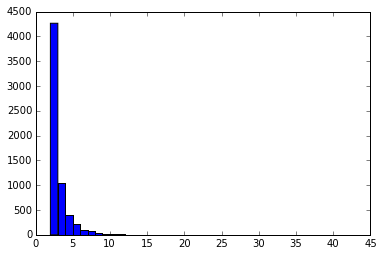

In [260]:
plt.hist(convLength.tolist(),42)

So yes, most conversations (defined by initial tweet) are very short

In [262]:
sum(inBBreps[inBBreps.convStart==264101449879928832].duplicated('lenRepSet'))

5

In [270]:
t=grouped.apply(lambda x: sum(x.duplicated('lenRepSet')))

find groups (convStarters) where there are duplicates (>0)

In [276]:
len(t[t>0])

369

So out of 6175 potential conversations, 369 have branching

So I can't just ignore these

In [280]:
len(t[t==1])

281

* 281 of those that have only one duplicate - definitely only 1 branch
* For these, we should just definitely combine it into a single conversation?

In [288]:
t=t[t>0]

In [313]:
inBBreps['branchConvo']=0

In [319]:
inBBreps.branchConvo=inBBreps.convStart.apply(lambda x: 1 if x in t.index.values else 0)

In [444]:
inBBreps.to_csv('../data/bbAllConvosDFmore.csv',sep=';')

How to handle conversational flow:
* for conversations with no branches, just pick the longest with this particular original
* for conversation with one branch: drop partials below the duplicate AND attach two branches (somehow)
* look into the cases with more than two branches to figure out how to stitch them together
* OR should I not?

# Construct DF for non-branching conversations

In [341]:
def getLongest(group):
    return group[group.lenRepSet==max(group.lenRepSet)]

In [348]:
g=(inBBreps[inBBreps.branchConvo==0]).groupby('convStart', as_index=False)

In [355]:
nonBranchConvos=g.apply(getLongest)

In [358]:
len(nonBranchConvos)

5806

In [404]:
def getOrigTime(row):
    i=43
    colName='reply'+str(i)+'OrigTime'
    while str(row[colName])=='0':
        i-=1
        colName='reply'+str(i)+'OrigTime'
        if i==1: #if reply2OrigTime is 0 - only one step
            colName='replyOrigTime'
    return row[colName]

In [399]:
nonBranchConvos['convStartTime']=0

In [405]:
nonBranchConvos.convStartTime=nonBranchConvos.apply(getOrigTime, axis=1)

In [429]:
nonBranchConvos['convLength']=(nonBranchConvos.dateObj-pd.to_datetime(nonBranchConvos.convStartTime)).apply(lambda x: np.nan if pd.isnull(x) else x.item()/(10**9))

In [430]:
data=nonBranchConvos.convLength.dropna().tolist()

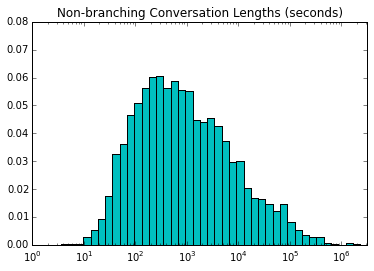

In [432]:
bins=np.logspace(0, int(np.log(max(data))), 100)
width=bins[1:]-bins[:-1]
h, b=np.histogram(data,bins)
h=h/float(sum(h))
plt.bar(b[:-1], h, width, color='c')
plt.gca().set_xscale("log")
plt.xlim(xmin=0,xmax=10**6.5)
plt.ylim(ymin=0,ymax=0.08)
plt.title('Non-branching Conversation Lengths (seconds)')

In [433]:
steps=nonBranchConvos.lenRepSet.dropna().tolist()

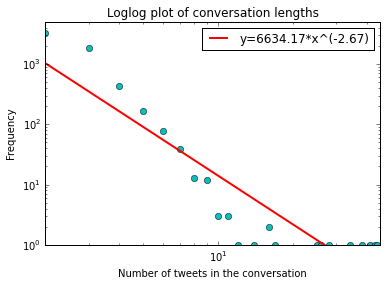

In [442]:
freq=c.Counter(steps)
y=freq.values()
x=freq.keys()
logx=np.log(x)
logy=np.log(y)
coeffs=np.polyfit(logx,logy,deg=1)
poly=np.poly1d(coeffs)
a=np.exp(coeffs[1])
b=coeffs[0]
eq='y='+str(round(a,2))+'*x^('+str(round(b,2))+')'

plt.figure()
plt.loglog(x,y,'co') 
plt.xlabel('Number of tweets in the conversation')
plt.ylabel('Frequency')
plt.title('Loglog plot of conversation lengths')
plt.xlim(xmin=-0,xmax=45)
plt.ylim(ymin=0,ymax=10**3.7)
yfit = lambda x: np.exp(poly(np.log(x)))
plt.loglog(x,yfit(x),linewidth=2,c='r',label=eq)
plt.legend(loc="upper right")

# Construct branching convesations

In [447]:
branch=inBBreps[inBBreps.branchConvo>0]

In [449]:
branch.head()

,id,username,user_id,geo_enabled,followCount,friendCount,faveCount,tweetCount,date,timing,...,reply43OrigText,reply43OrigReplyWhat,reply43OrigReplyWho,dateObj,repSecDiff,repSet,lenRepSet,convNames,convStart,branchConvo
3493,257086128446906368,terrymarley,24914924,True,584,676,36,5289,2012-10-13 11:51:24,before,...,0,0,0,2012-10-13 11:51:24,654,"set([257086128446906368, 257083385405661184])",2,"set([DalilaRobin, terrymarley])",257083385405661184,1
3501,257086614071816192,terrymarley,24914924,True,584,676,36,5289,2012-10-13 11:53:19,before,...,0,0,0,2012-10-13 11:53:19,769,"set([257086614071816192, 257083385405661184])",2,"set([DalilaRobin, terrymarley])",257083385405661184,1
9760,257310275651383296,SGottiR,187969481,True,131,249,519,8408,2012-10-14 02:42:04,before,...,0,0,0,2012-10-14 02:42:04,93,"set([257310275651383296, 257309882582192128])",2,"set([alexrodriguezNY, SGottiR])",257309882582192128,1
9762,257310426839257090,SGottiR,187969481,True,131,249,519,8408,2012-10-14 02:42:41,before,...,0,0,0,2012-10-14 02:42:41,130,"set([257309882582192128, 257310426839257090])",2,"set([alexrodriguezNY, SGottiR])",257309882582192128,1
10247,257325017489104896,mlbrisson,334286835,True,240,438,711,839,2012-10-14 03:40:39,before,...,0,0,0,2012-10-14 03:40:39,3441,"set([257325017489104896, 257310585488809984])",2,"set([adamebnit, mlbrisson])",257310585488809984,1


In [452]:
grouped=branch.groupby('convStart', as_index=False)

In [453]:
len(grouped)

369

In [457]:
b=branch.convStart[branch.lenRepSet==max(branch.lenRepSet)]

In [463]:
branch[branch.convStart==b.values[0]]

,id,username,user_id,geo_enabled,followCount,friendCount,faveCount,tweetCount,date,timing,...,reply43OrigText,reply43OrigReplyWhat,reply43OrigReplyWho,dateObj,repSecDiff,repSet,lenRepSet,convNames,convStart,branchConvo
253917,264103404769517568,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-01 20:35:33,after,...,0,0,0,2012-11-01 20:35:33,386,"set([264103404769517568, 264101788569960449, 2...",3,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
253954,264104422165078017,lopaz13,329752526,True,135,175,2,1782,2012-11-01 20:39:35,after,...,0,0,0,2012-11-01 20:39:35,242,"set([264103404769517568, 264104422165078017, 2...",4,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
254281,264110036358418432,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-01 21:01:54,after,...,0,0,0,2012-11-01 21:01:54,1339,"set([264110036358418432, 264104422165078017, 2...",5,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
254313,264110793908420608,lopaz13,329752526,True,135,175,2,1782,2012-11-01 21:04:54,after,...,0,0,0,2012-11-01 21:04:54,180,"set([264110793908420608, 264110036358418432, 2...",6,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
254456,264113775886622720,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-01 21:16:45,after,...,0,0,0,2012-11-01 21:16:45,711,"set([264113775886622720, 264110793908420608, 2...",7,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
262550,264248584067747840,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-02 06:12:26,after,...,0,0,0,2012-11-02 06:12:26,32852,"set([264248584067747840, 264110793908420608, 2...",7,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
262557,264249298353524736,lopaz13,329752526,True,135,175,2,1782,2012-11-02 06:15:16,after,...,0,0,0,2012-11-02 06:15:16,170,"set([264249298353524736, 264248584067747840, 2...",8,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
262566,264249636158595072,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-02 06:16:37,after,...,0,0,0,2012-11-02 06:16:37,81,"set([264249636158595072, 264249298353524736, 2...",9,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
262669,264255932849078272,lopaz13,329752526,True,135,175,2,1782,2012-11-02 06:41:38,after,...,0,0,0,2012-11-02 06:41:38,1501,"set([264255932849078272, 264249636158595072, 2...",10,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1
262675,264256331131805697,itsmeaRdo,56464727,True,160,218,167,3903,2012-11-02 06:43:13,after,...,0,0,0,2012-11-02 06:43:13,95,"set([264255932849078272, 264256331131805697, 2...",11,"set([itsmeaRdo, lopaz13, tirsarifka])",264101449879928832,1


How to deal with branching conversations:
* check how many of these potential convos (organized by the original) have more than 2 participants
* construct a set of all the tweets for each potential convo
* organize them by time and put into a data frame (see if there is a more efficient way - piecing them from existing)

In [471]:
def getBiggestGroup(group):
    m=max(group.convNames.apply(lambda x: len(x)))
    return m

In [474]:
convPeople=grouped.apply(getBiggestGroup)

In [475]:
len(convPeople[convPeople>2])

60

In [476]:
max(convPeople)

4

So 60 out of the 369 branching conversations are with **three** or **four** people